In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import matplotlib.patches as mpatches

In [261]:
custom_style = {
    "axes.facecolor": "#f2f2e3",  # Background color
    "axes.labelcolor": "#3f2423",  # Label color
    "axes.labelweight": "bold",  # Label weight
    "axes.labelsize": 12,  # Label size
    "axes.labelpad": 10,  # Label padding
    "axes.titlesize": 15,  # Title size
    "axes.titleweight": "bold",  # Title weight
    "axes.titlecolor": "#3f2423",  # Title color
    "axes.titlepad": 15,  # Title padding
    "axes.edgecolor": "#b9b7bd",  # Axes edge color
    "axes.grid": True,  # Show grid
    "grid.color": "white",  # Grid color
    "xtick.color": "#b9b7bd",  # X-tick color
    "ytick.color": "#b9b7bd",  # Y-tick color
    "font.family": "Roboto, sans-serif",  # Font family
    "legend.fontsize": 10,  # Legend font size
    "legend.title_fontsize": 12,  # Legend title font size
    "legend.edgecolor": "#3f2423",  # Legend edge color
    "legend.facecolor": "#f2f2e3",  # Legend face color
    "legend.labelcolor": "#3f2423",  # Legend label color
}
plt.style.use(custom_style)
sns.set_context("notebook", rc=custom_style)
sns.set_style("darkgrid", {'axes.facecolor': '#f2f2e3', 'grid.color': '#f2f2e3'})

In [262]:
df = pd.read_csv('../data/SBA_cleaned.csv', low_memory=False)

## 3. Data Exploration

In [263]:
def cat_summary(col, return_styler=True):
    print(f"There are {df[col].nunique()} unique classes in '{str(col)}' feature. ")
    counts = df[col].value_counts()
    prop = round((counts / counts.sum())*100, 2)
    prop_df = pd.DataFrame({
        'Class': counts.index, 
        'Count': counts.values,
        'Proportion (%)' : prop.values
    }).round(2)
    styled_prop_df =  prop_df.style.apply(lambda s: ['background-color: lightgreen' if v == s.max() else 'background-color:lightcoral' if v == s.min() else '' for v in s], subset=['Proportion (%)'])
    
    if return_styler:
        return styled_prop_df.format({'Proportion (%)': '{:.2f}'})

    else:
        print('\n', styled_prop_df)

In [264]:
to_drop=[]
def cols_to_drop(col):
    to_drop.append(col)

### 3.1 MIS_Status and Default

In [265]:
cat_summary('MIS_Status')

There are 2 unique classes in 'MIS_Status' feature. 


,Class,Count,Proportion (%)
0,P I F,539399,79.59
1,CHGOFF,138286,20.41


In [266]:
cat_summary('Default')

There are 2 unique classes in 'Default' feature. 


,Class,Count,Proportion (%)
0,0,539399,79.59
1,1,138286,20.41


In [267]:
# Both Default and MIS_status are same
# 0 in Defualt is same as P I F in MIS_status and viceversa.
cols_to_drop('MIS_Status')

#### 3.1.1 Distribution of Defaulted Status

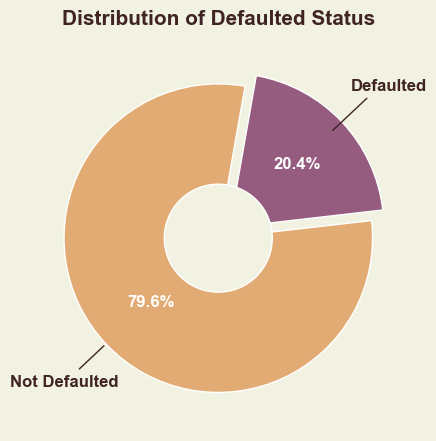

In [268]:
default_count = df['Default'].value_counts()

default_labels = ['Not Defaulted', 'Defaulted']
default_colors = ['#e3ab74', '#955c7f']

fig, ax = plt.subplots(figsize=(5, 5), facecolor='#f2f2e3')
wedges, texts, autotexts = ax.pie(default_count, autopct='%1.1f%%',explode= (0, 0.1), startangle=80, colors=default_colors, textprops={'fontweight': 'bold', 'fontsize': 12, 'color': 'white'})

plt.title('Distribution of Defaulted Status')

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    y = np.sin(np.deg2rad(angle))
    x = np.cos(np.deg2rad(angle))
    horizontalalignment = 'center' if x == 0 else ('right' if x > 0 else 'left')
    connectionstyle = "angle,angleA=0,angleB={}".format(angle)
    ax.annotate(default_labels[i],
                xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                horizontalalignment=horizontalalignment, fontsize=12, color='#3f2423',
                weight='bold',
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='#3f2423'))
centre_circle = plt.Circle((0,0),0.35,fc='#f2f2e3')
fig.gca().add_artist(centre_circle)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

- There are 20.4% of defaulted customers.

### 3.2 City and State

In [269]:
cat_summary('State')

There are 51 unique classes in 'State' feature. 


,Class,Count,Proportion (%)
0,CA,99066,14.62
1,TX,51558,7.61
2,NY,44692,6.59
3,FL,32913,4.86
4,PA,27530,4.06
5,OH,24912,3.68
6,IL,23179,3.42
7,MA,20035,2.96
8,NJ,18825,2.78
9,MN,18363,2.71


#### 3.2.1 Distribution of Default rate of Loans disbursed by State

### 3.3 Sector 

#### 3.3.1 Distribution of Sectors by there count and Sector Rate

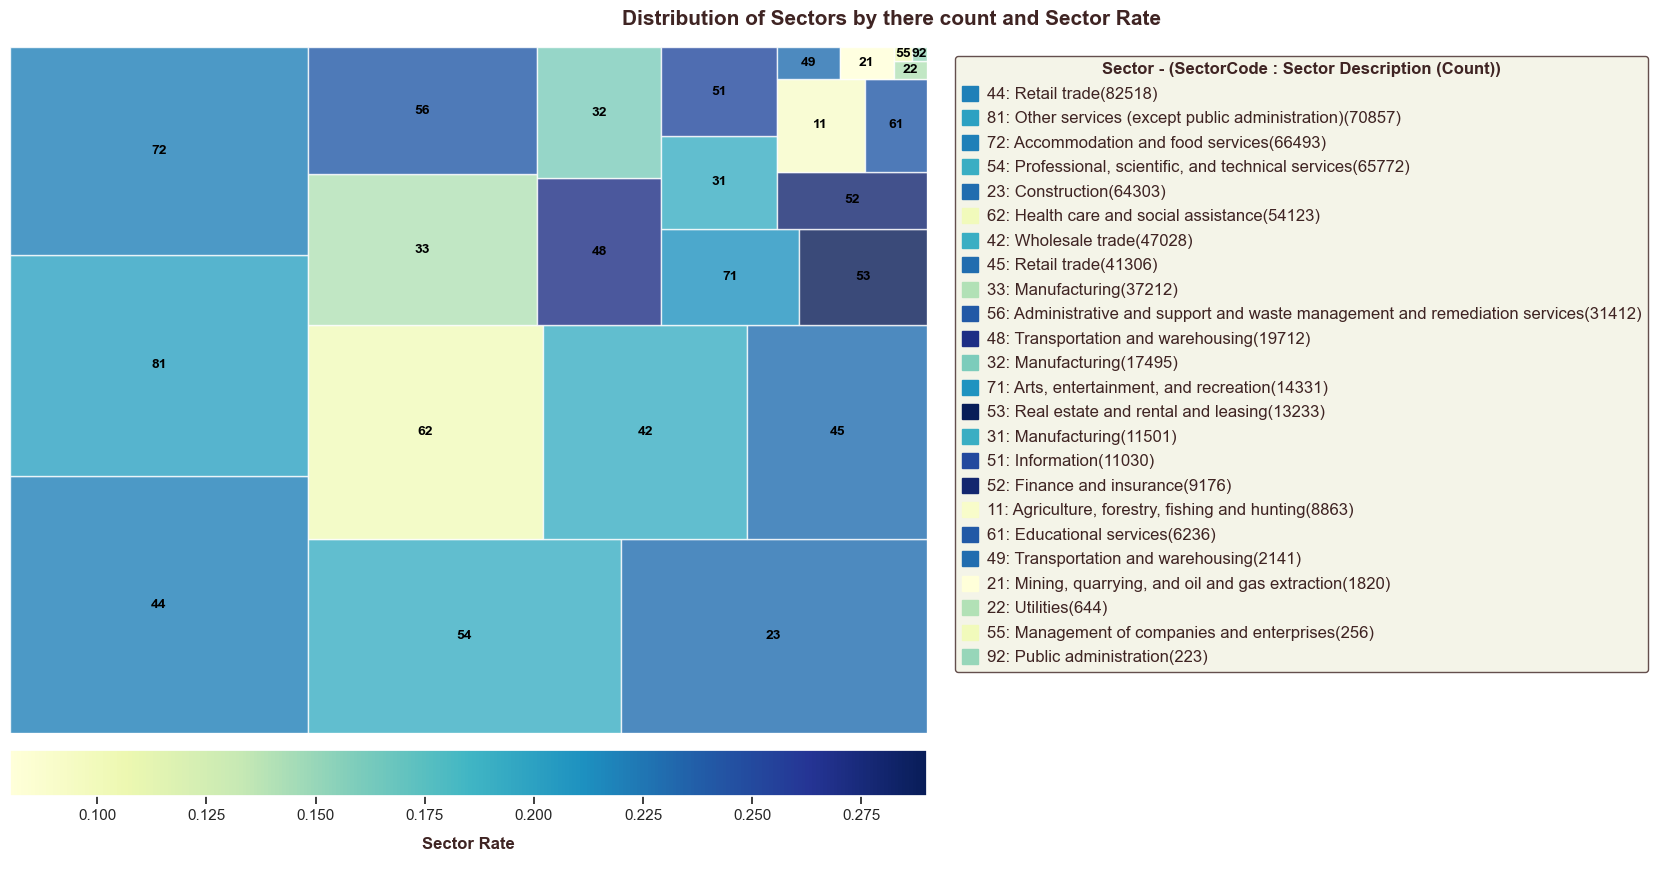

In [270]:
sector_counts = df.groupby('SectorCode').size().reset_index(name='Count')
sector_data = df[['SectorCode', 'SectorDesc', 'SectorRate']].drop_duplicates(subset=['SectorCode', 'SectorDesc', 'SectorRate'])
sector_df = pd.merge(sector_data, sector_counts, on='SectorCode')
sector_df = sector_df.sort_values(by='Count', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), gridspec_kw={'width_ratios': [1.5, 1]})

norm = plt.Normalize(vmin = sector_df['SectorRate'].min(), vmax = sector_df['SectorRate'].max())
colors = plt.cm.YlGnBu(norm(sector_df['SectorRate']))

squarify.plot(
    sizes=sector_df['Count'],
    label=sector_df['SectorCode'],
    color=colors,
    alpha=0.8,
    text_kwargs={'fontsize': 10, 'color': 'black', 'weight': 'bold'},
    ax=ax1
)

sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.02, ax=ax1)
cbar.set_label('Sector Rate', fontsize=12, color = '#3f2423')

legend_labels = [f"{code}: {desc}({count})" for code, desc, count in zip(sector_df['SectorCode'], sector_df['SectorDesc'], sector_df['Count'])]
handles = [mpatches.Rectangle((0, 0), 1, 1, color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax2.axis('off') 
legend =ax2.legend(title='Sector - (SectorCode : Sector Description (Count))',handles=handles, loc='upper left', fontsize=12, handlelength=1.0, handleheight=1.0, handletextpad=0.5)
legend.get_title().set_fontweight('bold')
legend.get_title().set_color('#3f2423')

fig.suptitle('Distribution of Sectors by there count and Sector Rate', fontsize=15, fontweight='bold', color = '#3f2423')
ax1.axis('off') 
plt.subplots_adjust(wspace=0.3) 
plt.tight_layout()

plt.show()

#### 3.3.2 Distribution of Defaults by Sector

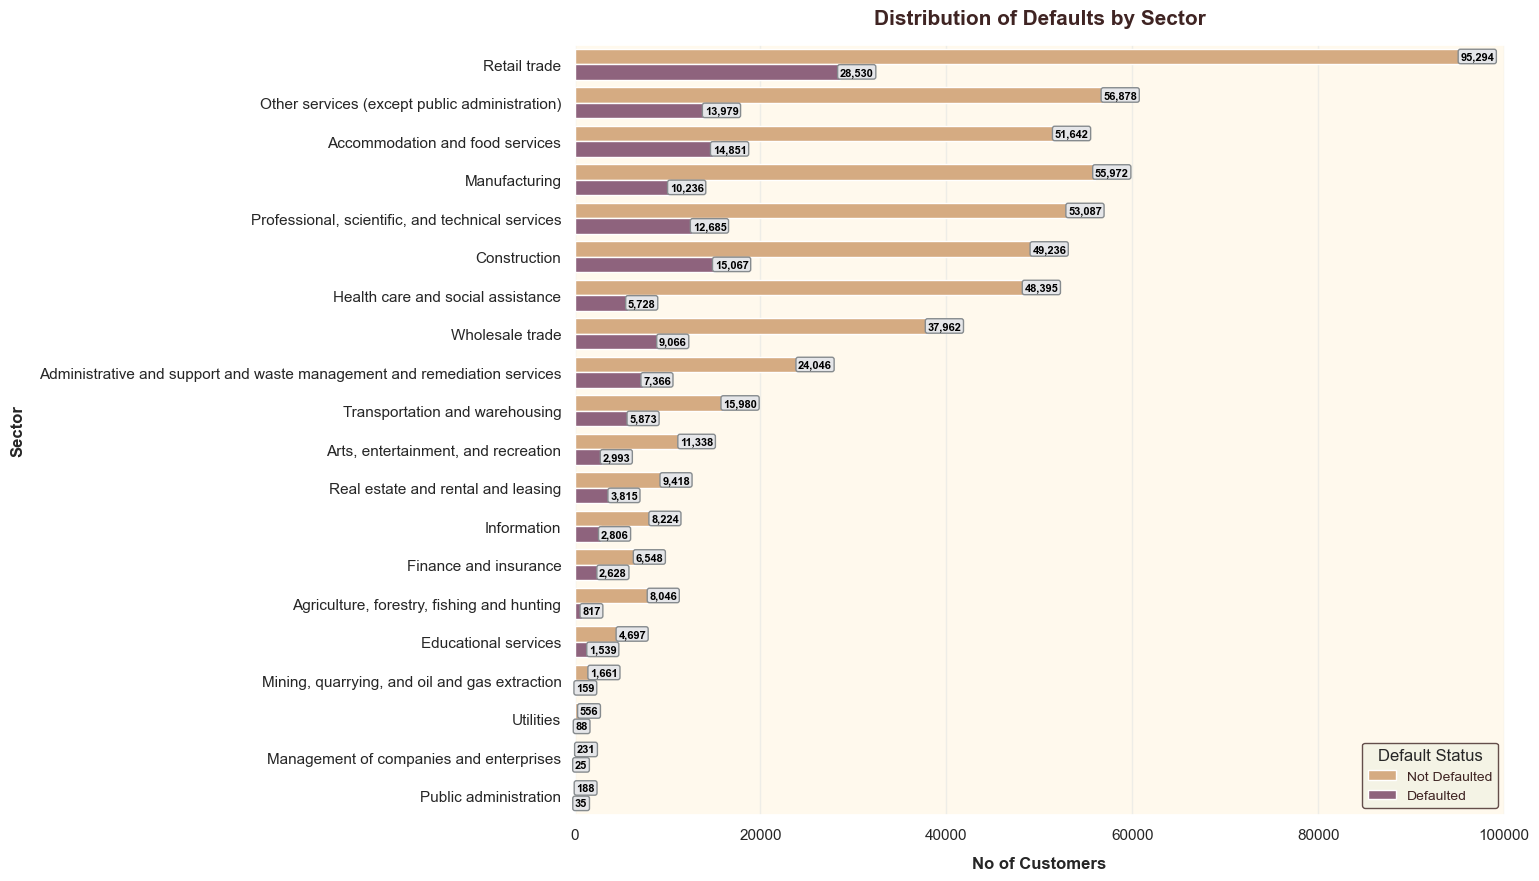

In [271]:
plt.figure(figsize=(12, 10))
ax = sns.countplot(data=df, y='SectorDesc', hue='Default', palette=default_colors, order=df['SectorDesc'].value_counts().index, edgecolor=None)
plt.title('Distribution of Defaults by Sector')
plt.xlabel('No of Customers')
plt.ylabel('Sector')
plt.legend(labels=default_labels, loc = 'lower right', title='Default Status')
ax.xaxis.grid(True, linestyle='-', color='#eeede7') 
ax.set_facecolor('#FFF9ED')  
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}',
                (p.get_width() + 10, p.get_y() + p.get_height() / 2 ),
                ha='left', va='center', fontsize=8, color='black', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1))

#### 3.3.3 Active number of Loans during great Recession by Sector

In [272]:
cat_summary('Recession')

There are 2 unique classes in 'Recession' feature. 


,Class,Count,Proportion (%)
0,0,617552,91.13
1,1,60133,8.87


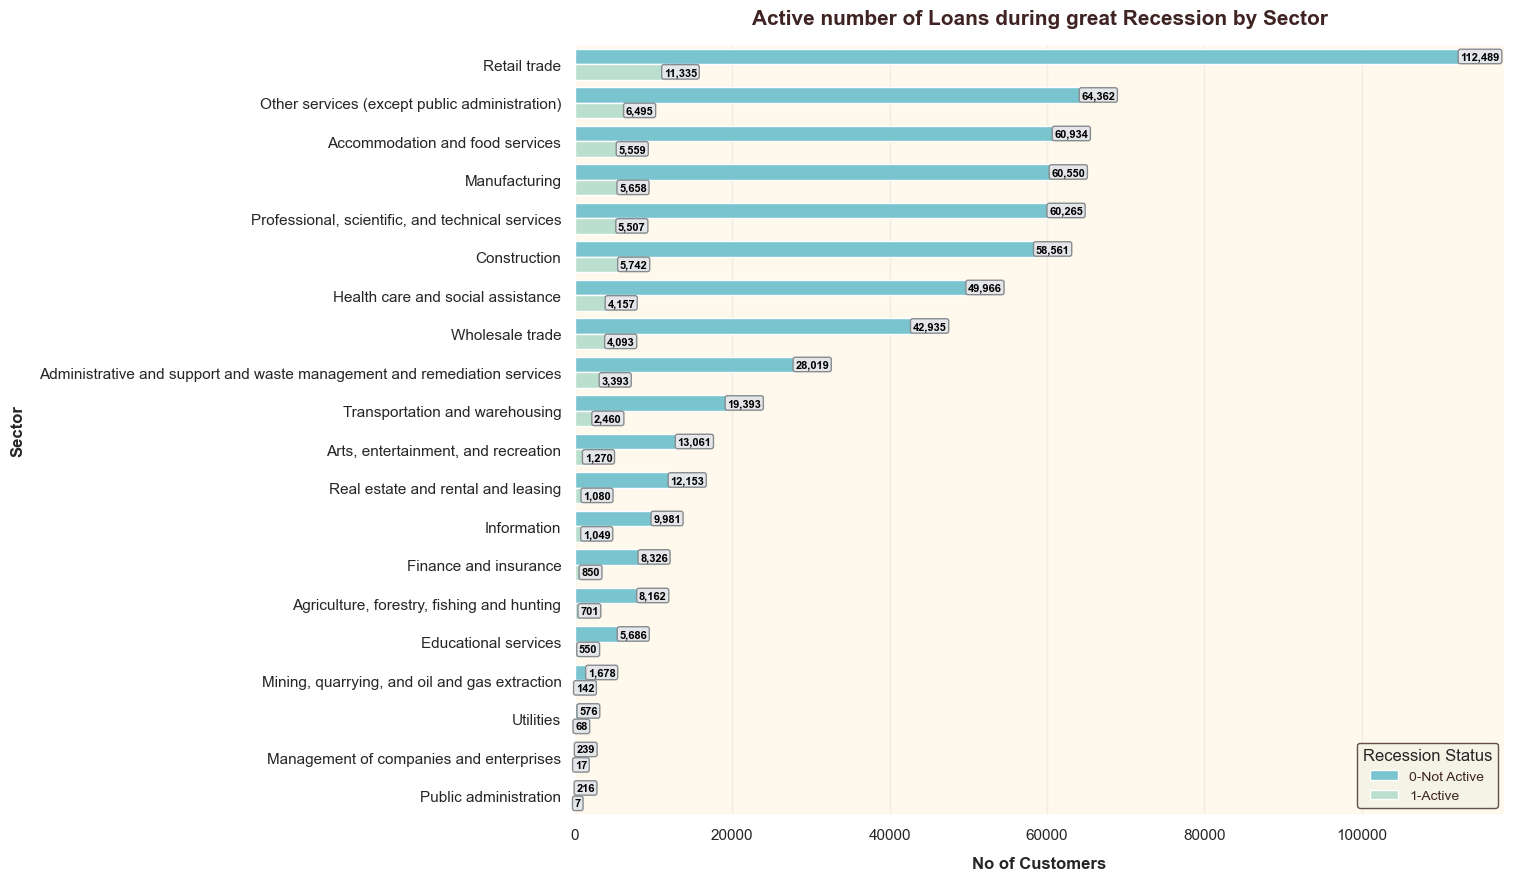

In [273]:
plt.figure(figsize=(12, 10))
recession_colors = ['#6bcfdc', '#b5e5cf']
rec_labels = ['0-Not Active', '1-Active']
ax = sns.countplot(data=df, y='SectorDesc', hue='Recession', palette=recession_colors, order=df['SectorDesc'].value_counts().index, edgecolor=None)
plt.title('Active number of Loans during great Recession by Sector')
plt.xlabel('No of Customers')
plt.ylabel('Sector')
plt.legend(labels=rec_labels, loc = 'lower right', title='Recession Status')
ax.xaxis.grid(True, linestyle='-', color='#eeede7') 
ax.set_facecolor('#FFF9ED')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}',
                (p.get_width() + 10, p.get_y() + p.get_height() / 2 ),
                ha='left', va='center', fontsize=8, color='black', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1))

In [274]:
df.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'IsJobCreated', 'IsJobRetained',
       'IsFranchised', 'SectorCode', 'SectorDesc', 'SectorRate', 'New',
       'SBA_portion', 'RealEstate', 'Default', 'DaysTerm', 'xx', 'Recession',
       'StateRate'],
      dtype='object')

### 3.4 RevLineCr - Revolving line of credit

In [275]:
cat_summary('RevLineCr')

There are 2 unique classes in 'RevLineCr' feature. 


,Class,Count,Proportion (%)
0,N,484081,71.43
1,Y,193604,28.57


#### 3.4.1 Loan Default Status by Revolving Line of Credit

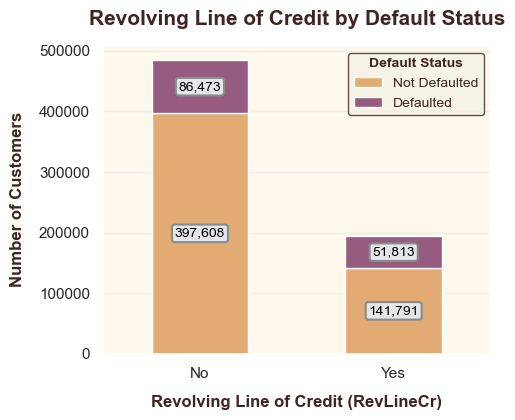

In [276]:
realestate_default = df.groupby(['RevLineCr', 'Default']).size().unstack()

fig, ax = plt.subplots(figsize=(5,4))
realestate_default.plot(kind='bar', stacked=True, ax=ax, color=[default_colors[col] for col in realestate_default.columns])

for i, (index, row) in enumerate(realestate_default.iterrows()):
    for j, value in enumerate(row):
        ax.text(i, row.cumsum()[j] - value / 2, f'{value:,}', ha='center', va='center', fontsize= 10, color='black', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
ax.xaxis.grid(True, linestyle='-', color='white') 
ax.set_xlabel('Revolving Line of Credit (RevLineCr)', color='#3f2423')
ax.set_ylabel('Number of Customers', color='#3f2423')
ax.set_title('Revolving Line of Credit by Default Status', color='#3f2423')
ax.set_facecolor('#FFF9ED')
ax.set_xticklabels(['Yes' if tick == 'Y' else 'No' for tick in realestate_default.index], rotation=0)
ax.yaxis.grid(True, color = '#eeede7')
ax.xaxis.grid(False)
legend = ax.legend(title='Default Status', labels=default_labels)
plt.setp(legend.get_title(), fontsize=10, fontweight='bold', color='#3f2423')
plt.show()

In [277]:
df.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'IsJobCreated', 'IsJobRetained',
       'IsFranchised', 'SectorCode', 'SectorDesc', 'SectorRate', 'New',
       'SBA_portion', 'RealEstate', 'Default', 'DaysTerm', 'xx', 'Recession',
       'StateRate'],
      dtype='object')

### 3.5 LowDoc - LowDoc Loan Program

In [278]:
cat_summary('LowDoc')

There are 2 unique classes in 'LowDoc' feature. 


,Class,Count,Proportion (%)
0,N,608197,89.75
1,Y,69488,10.25


#### 3.5.1 Default Status in LowDoc Loan Program

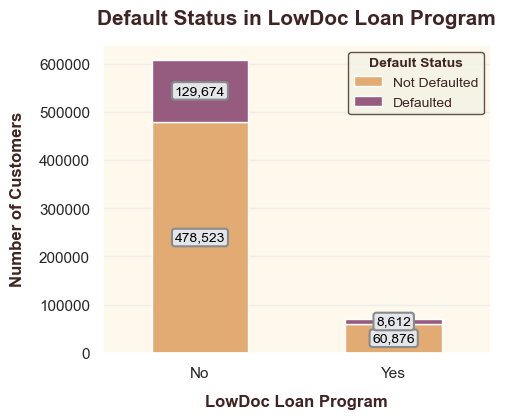

In [279]:
realestate_default = df.groupby(['LowDoc', 'Default']).size().unstack()

fig, ax = plt.subplots(figsize=(5,4))
realestate_default.plot(kind='bar', stacked=True, ax=ax, color=[default_colors[col] for col in realestate_default.columns])

for i, (index, row) in enumerate(realestate_default.iterrows()):
    for j, value in enumerate(row):
        ax.text(i, row.cumsum()[j] - value / 2, f'{value:,}', ha='center', va='center', fontsize= 10, color='black', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
ax.xaxis.grid(True, linestyle='-', color='white') 
ax.set_xlabel('LowDoc Loan Program', color='#3f2423')
ax.set_ylabel('Number of Customers', color='#3f2423')
ax.set_title('Default Status in LowDoc Loan Program', color='#3f2423')
ax.set_facecolor('#FFF9ED')
ax.set_xticklabels(['Yes' if tick == 'Y' else 'No' for tick in realestate_default.index], rotation=0)
ax.yaxis.grid(True, color = '#eeede7')
ax.xaxis.grid(False)
legend = ax.legend(title='Default Status', labels=default_labels)
plt.setp(legend.get_title(), fontsize=10, fontweight='bold', color='#3f2423')
plt.show()

### 3.6 New - New Business or Existing Business

In [280]:
cat_summary('New')

There are 2 unique classes in 'New' feature. 


,Class,Count,Proportion (%)
0,0,488575,72.09
1,1,189110,27.91


#### 3.6.1 Default Status by Business Type: New vs. Existing

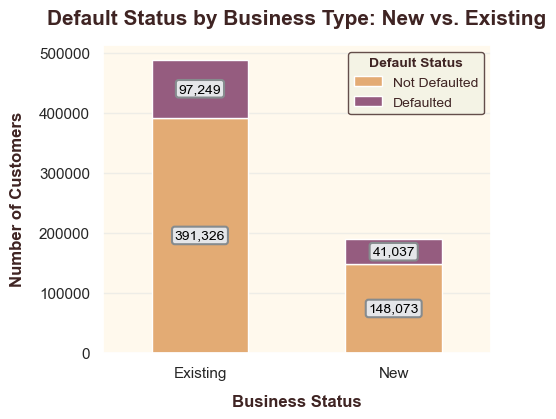

In [281]:
realestate_default = df.groupby(['New', 'Default']).size().unstack()

fig, ax = plt.subplots(figsize=(5,4))
realestate_default.plot(kind='bar', stacked=True, ax=ax, color=[default_colors[col] for col in realestate_default.columns])

for i, (index, row) in enumerate(realestate_default.iterrows()):
    for j, value in enumerate(row):
        ax.text(i, row.cumsum()[j] - value / 2, f'{value:,}', ha='center', va='center', fontsize= 10, color='black', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
ax.xaxis.grid(True, linestyle='-', color='white') 
ax.set_xlabel('Business Status', color='#3f2423')
ax.set_ylabel('Number of Customers', color='#3f2423')
ax.set_title('Default Status by Business Type: New vs. Existing', color='#3f2423')
ax.set_facecolor('#FFF9ED')
ax.set_xticklabels(['New' if tick == 1 else 'Existing' for tick in realestate_default.index], rotation=0)
ax.yaxis.grid(True, color = '#eeede7')
ax.xaxis.grid(False)
legend = ax.legend(title='Default Status', labels=default_labels)
plt.setp(legend.get_title(), fontsize=10, fontweight='bold', color='#3f2423')
plt.show()

### 3.7 Real EState - Loan is backed by real estate

In [282]:
cat_summary('RealEstate')

There are 2 unique classes in 'RealEstate' feature. 


,Class,Count,Proportion (%)
0,0,580032,85.59
1,1,97653,14.41


#### 3.7.1 Default Status by Real Estate: Backed vs Non-backed

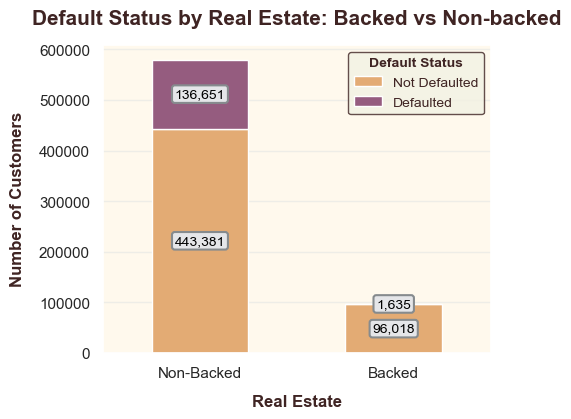

In [283]:
realestate_default = df.groupby(['RealEstate', 'Default']).size().unstack()

fig, ax = plt.subplots(figsize=(5,4))
realestate_default.plot(kind='bar', stacked=True, ax=ax, color=[default_colors[col] for col in realestate_default.columns])

for i, (index, row) in enumerate(realestate_default.iterrows()):
    for j, value in enumerate(row):
        ax.text(i, row.cumsum()[j] - value / 2, f'{value:,}', ha='center', va='center', fontsize= 10, color='black', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
ax.xaxis.grid(True, linestyle='-', color='white') 
ax.set_xlabel('Real Estate', color='#3f2423')
ax.set_ylabel('Number of Customers', color='#3f2423')
ax.set_title('Default Status by Real Estate: Backed vs Non-backed', color='#3f2423')
ax.set_facecolor('#FFF9ED')
ax.set_xticklabels(['Backed' if tick == 1 else 'Non-Backed' for tick in realestate_default.index], rotation=0)
ax.yaxis.grid(True, color = '#eeede7')
ax.xaxis.grid(False)
legend = ax.legend(title='Default Status', labels=default_labels)
plt.setp(legend.get_title(), fontsize=10, fontweight='bold', color='#3f2423')
plt.show()

### 3.8 Term

#### 3.8.1 Distribution of Loan Term by Default Status

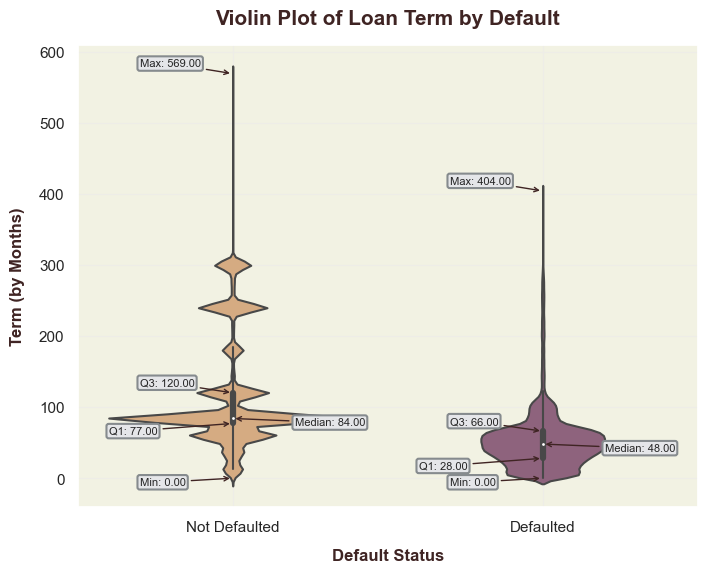

In [286]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='Term', data=df, labels=default_labels, palette=default_colors)
plt.xlabel('Default Status', color='#3f2423')
plt.ylabel('Term (by Months)', color='#3f2423')
plt.title('Violin Plot of Loan Term by Default')

def annotate_vplot(ax, df, feature):
    stats = df.groupby('Default')[feature].describe()
    for i in range(len(stats)):
        violin_data = df[df['Default'] == i][feature]
        ax.annotate(f'Min: {violin_data.min():.2f}', xy=(i, violin_data.min()), xytext=(i-0.3, violin_data.min()-10),
                    arrowprops=dict(facecolor='black', arrowstyle='->', edgecolor='#3f2423'), fontsize='8',bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
        ax.annotate(f'Q1: {stats.loc[i, "25%"]:.2f}', xy=(i, stats.loc[i, "25%"]), xytext=(i-0.4, stats.loc[i, "25%"]-15),
                    arrowprops=dict(facecolor='black', arrowstyle='->', edgecolor='#3f2423'), fontsize='8', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
        ax.annotate(f'Median: {stats.loc[i, "50%"]:.2f}', xy=(i, stats.loc[i, "50%"]), xytext=(i+0.2, stats.loc[i, "50%"]-10),
                    arrowprops=dict(facecolor='black', arrowstyle='->', edgecolor='#3f2423'), fontsize='8', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
        ax.annotate(f'Q3: {stats.loc[i, "75%"]:.2f}', xy=(i, stats.loc[i, "75%"]), xytext=(i-0.3, stats.loc[i, "75%"]+10),
                    arrowprops=dict(facecolor='black', arrowstyle='->', edgecolor='#3f2423'), fontsize='8', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))
        ax.annotate(f'Max: {violin_data.max():.2f}', xy=(i, violin_data.max()), xytext=(i-0.3, violin_data.max()+10),
                    arrowprops=dict(facecolor='black', arrowstyle='->', edgecolor='#3f2423'), fontsize='8', bbox=dict(boxstyle="round,pad=0.2", fc="#e5e6e9", ec="#868b8e", lw=1.5))

annotate_vplot(plt.gca(), df, 'Term')
plt.gca().grid(True, color='#eeede7')
plt.xticks([0, 1], ['Not Defaulted', 'Defaulted'])
plt.show()

#### 3.8.2 Distribution of Loan Length by Sector

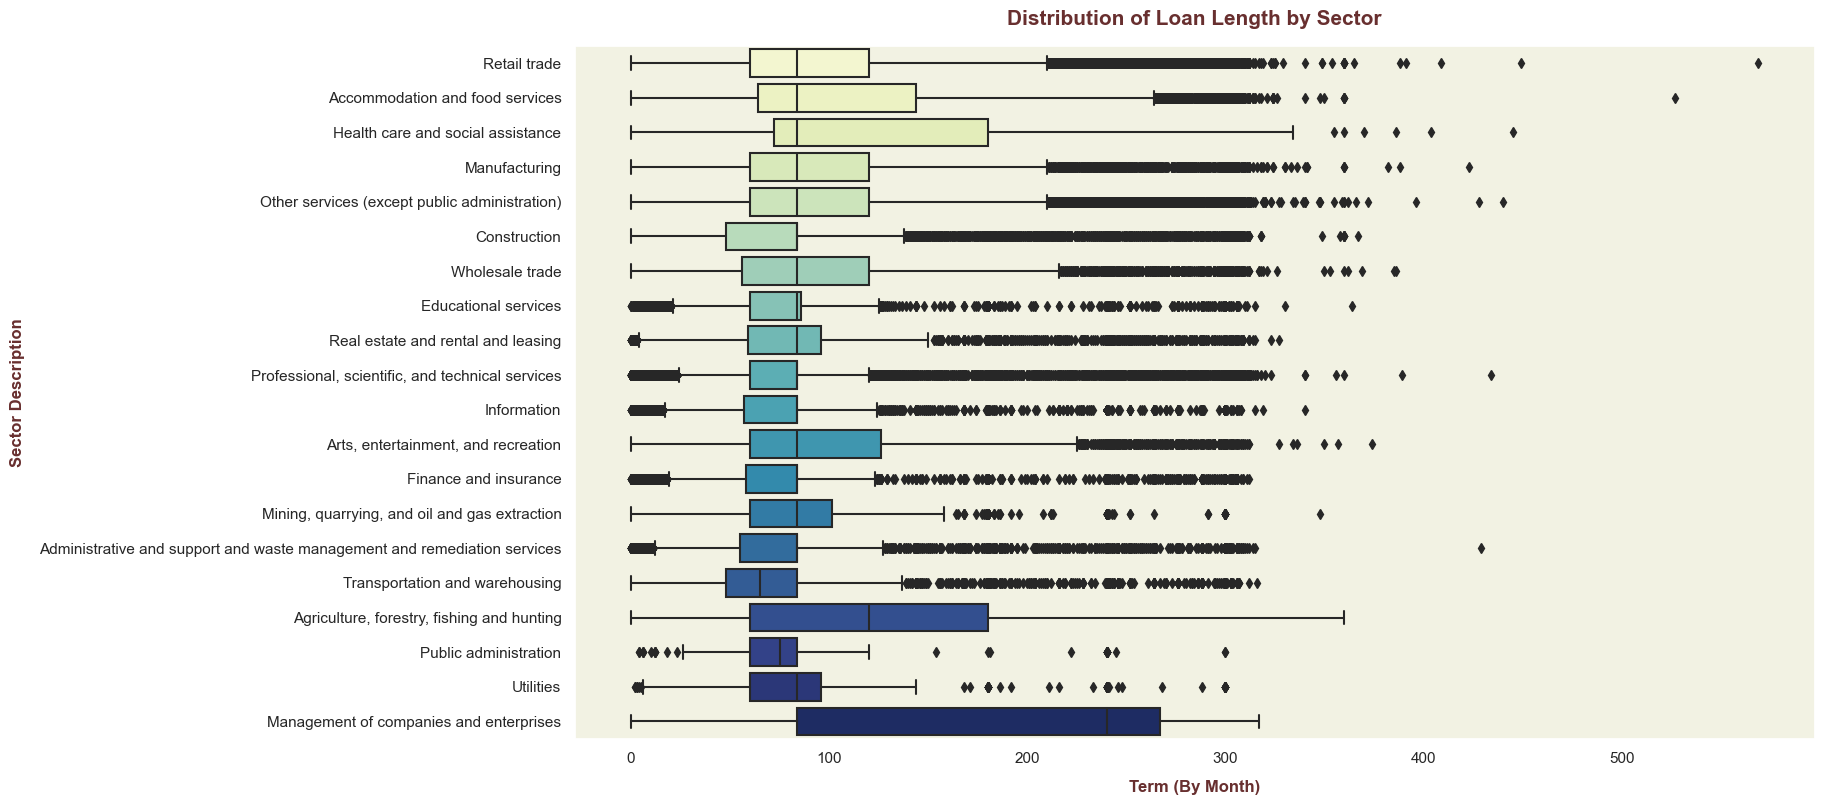

In [285]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x="Term", y="SectorDesc", data=df, palette='YlGnBu')
plt.title('Distribution of Loan Length by Sector', fontsize=15, color='#682F2F')
plt.xlabel('Term (By Month)', fontsize=12, color='#682F2F')
plt.ylabel('Sector Description', color='#682F2F')
plt.show()